In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, auc, roc_curve, f1_score, r2_score, confusion_matrix, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.utils.set_random_seed(0)

In [ ]:
imgs_np = []

In [ ]:
lista = ['Apple A', 'Apple B', 'Apple C','Apple D','Apple E','Apple F']
apples = []


In [ ]:
#wczytanie ścieżek zdjęć i labeli z google drive
for folder in lista:
  tmp = []
  tmp = glob(f'/content/drive/MyDrive/Colab Notebooks/Apple/{folder}/*')
  f_name = len(tmp)*[folder]
  apples += list(zip(tmp, f_name))


In [ ]:
apples[5684]

('/content/drive/MyDrive/Colab Notebooks/Apple/Apple F/Apple F _0_7334.png',
 'Apple F')

In [ ]:
len(apples)

6161

In [ ]:
# stworzenie df
df = pd.DataFrame(apples, columns=['path', 'fruit'])
df

,path,fruit
0,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A
1,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A
2,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A
3,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A
4,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A
...,...,...
6156,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple F
6157,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple F
6158,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple F
6159,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple F


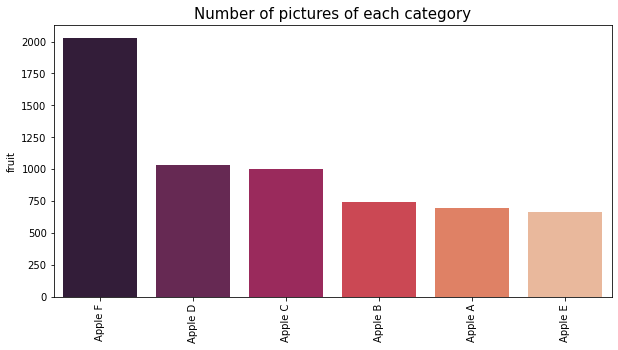

In [ ]:
# wykres liczebności kategorii
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

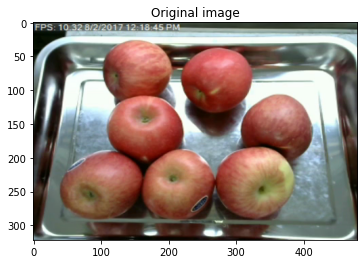

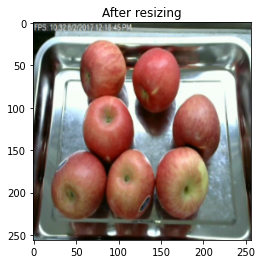

In [ ]:
#zmiana rozdzielczosci pojedynczego zdjecia i wyswietlenie
img = plt.imread(df.path[0])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (256,256)))
plt.title("After resizing")
plt.show()

In [ ]:
# dodanie do df kolumny label ze zmapowanymi kategoriami
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

{'Apple A': 0, 'Apple B': 1, 'Apple C': 2, 'Apple D': 3, 'Apple E': 4, 'Apple F': 5}


In [ ]:
def load_img(df, size):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (size,size))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [ ]:
# przemieszanie danych w dfie
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

In [ ]:
#wyświetlenie wyniku przemieszania
df[:600]

,path,fruit,label
0,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple D,3
1,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple D,3
2,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple D,3
3,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple F,5
4,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A,0
...,...,...,...
595,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple F,5
596,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple D,3
597,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple D,3
598,/content/drive/MyDrive/Colab Notebooks/Apple/A...,Apple A,0


In [ ]:
# funkcja budująca model z otrzymanych parametrow
def build_model(conv2D_num:int, filters_num:list, classNum=6):
    if conv2D_num != len(filters_num):
        print('liczba warstw ukrytych nie pokrywa się z liczbą neuronów')
    else:
        shape_img = (128,128,3)
        model = keras.Sequential()

        model.add(keras.layers.InputLayer(input_shape=shape_img))

        for i in range(1, conv2D_num+1):
            model.add(keras.layers.Conv2D(filters_num[i-1], kernel_size=(3,3), activation='relu'))
            model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(30, activation='relu'))
        model.add(keras.layers.Dense(classNum, name='wyjscie'))
        model.add(keras.layers.Softmax())
        
        model.summary()
        
        opt = keras.optimizers.Adam()
        model.compile(optimizer=opt, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

        return model


In [ ]:
#wczytanie wszytskich danych
x, y = load_img(df[:], 128)

In [ ]:
x.shape, y.shape

((6161, 128, 128, 3), (6161,))

In [ ]:
# Podział na próby
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4928, 128, 128, 3), (1233, 128, 128, 3), (4928,), (1233,))

In [ ]:
# instancja modelu
model = build_model(2, [4, 4])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 4)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 30)                1

Epoch 1/10
198/198 [==============================] - 10s 9ms/step - loss: 0.5458 - accuracy: 0.8354 - val_loss: 0.1005 - val_accuracy: 0.9767
Epoch 2/10
198/198 [==============================] - 1s 7ms/step - loss: 0.0565 - accuracy: 0.9886 - val_loss: 0.0399 - val_accuracy: 0.9899
Epoch 3/10
198/198 [==============================] - 1s 7ms/step - loss: 0.0211 - accuracy: 0.9970 - val_loss: 0.0172 - val_accuracy: 0.9939
Epoch 4/10
198/198 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9995 - val_loss: 0.0165 - val_accuracy: 0.9959
Epoch 5/10
198/198 [==============================] - 1s 6ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 0.9980
Epoch 6/10
198/198 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9970
Epoch 7/10
198/198 [==============================] - 1s 7ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9970
Epoch

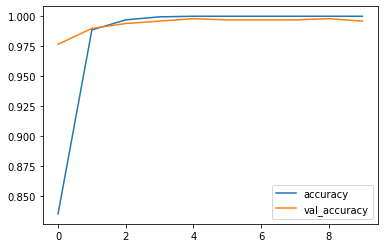

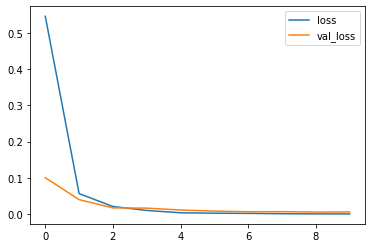

In [ ]:
# trening modelu
results = model.fit(x=x_train, y=y_train, batch_size=20, epochs=10, verbose=1, validation_split = 0.2, shuffle=True)

df_res = pd.DataFrame.from_dict(results.history)
df_res
df_res.plot(y = ['accuracy', 'val_accuracy'])
df_res.plot(y = ['loss', 'val_loss'])

In [ ]:
#Predykcja
y_pred = model.predict(x_test)

39/39 [==============================] - 0s 5ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)

In [ ]:
import itertools
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

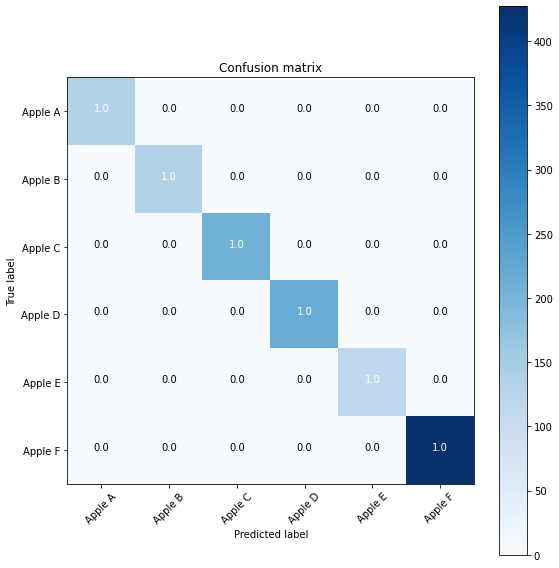

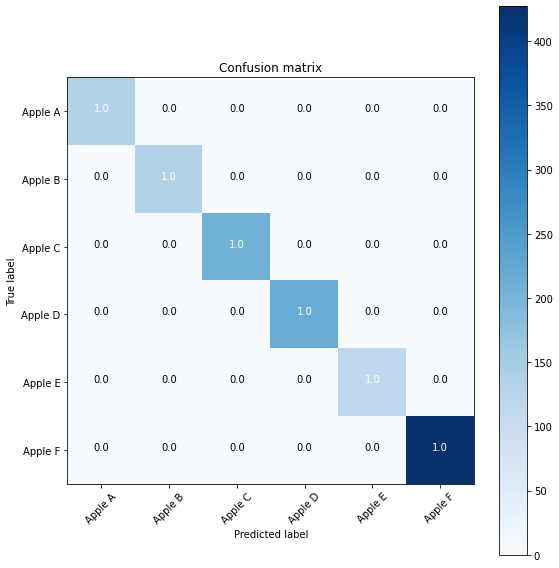

In [ ]:
plot_confusion_matrix(cm, class_names = lista)